# Module 2 Final Project Submission
This is an assignment and is a fictional study by Pat Fuller and Mia Iseman. All references, though they may exist, are not aware of this project or involved in any way.  
* <a href="https://github.com/MIAISEMAN/mod_2_project">Repository URL </a>
* <a href="https://docs.google.com/presentation/d/1iFk_YmiKlzh46s8aogALnfsZf9R_KxXqXBvpXvXAoNE/edit?usp=sharing">Presentation URL </a>

# Goal: 
## Deliver insights to help Lou Taylor decide on which musicians to manage or book for residences in Vegas. 

# Process
1. Understand the business needs.
2. Understand the data overall. 
3. For each hypothesis:  
    A. Understand the data.  
    B. Prepare the data.  
    C. Test the hypothesis.   
    D. Evaluate our results.  
4. Deploy our project.

# Business Understanding 

Lou Taylor, one of the most successful managers for musicians, boasts an all-star roster of clients, including Steven Tyler, Gwen Stefani, Florida Georgia Line and J Lo's Vegas residency. 

She has hired us to deliver insights about several factors that might help her decide on which artists to manage or book for residences in Vegas. As a jumping off point, we will answer the following questions:  
<b>
1. Are self-released albums scored lower than the wider population?  
2. Are "best new music" albums more prevalent in a certain genre?
3. Of the ten most prolific labels, does one label have more "best new music" albums than the others?
4. Does one reviewer score albums lower than all others? 
5. Of the top ten highest-rated artists from the 2000s, does their recent album get scored better than average? </b>

## Understand the Data Overall 
For this project we used the <a href="https://www.kaggle.com/nolanbconaway/pitchfork-data"> Kaggle Pitchfork dataset</a>, which is over 18,000 reviews of musical albums from <a href="https://pitchfork.com/reviews/albums/Pitchfork"> Pitchfork</a> published between 1999 and 2017. 

One limitation of our dataset is that all these music reviews come from the same company, Pitchfork. As such, our tests are not technically random. (What if other websites for music reviews operate much differently? What if we had data from before 1999 or after 2017, which is not the case here? Most importantly, what if Pitchfork only reviews a certain subset of the overall album population?) Since it is the dataset that we have, it will serve as "random enough." 

Similarly, another limitation of our findings is that in order to test the data and in order for our results to be relevant at all, we will interpret the entire Pitchfork review dataset as our "wider population." 

# 1. Are self-released albums scored lower than the wider population?

## Understand the data

### Data Details
Each review is for an album which is released by a record label, except in the case of the self-released albums. They are released by the artists themselves. 
We want to know if self-released albums get lower scores in their reviews than the wider population. 

### Hypotheses
<b> $H_0=$ Self-released albums are scored the same as or higher than the wider population.

$H_a=$ Self-released albums are scored lower than the wider population. </b>

### Statistical Significance
Even if we find that self-released albums are typically scored lower, we only want to know if this is a $statistically significant$ amount lower. Therefore, we'll decide on an $alpha$ value that will indicate the number of false positives we are comfortable having. As the chance of false positives goes up, the chance of false negatives goes down and vie versa. So we want to think about which one we are more comfortable getting. In this case, a false positive (type 1 error) would be that we say self-released albums are scored lower but they are not scored lower. A false negative (type 2 error), would be that we say self-released albums are scored the same or higher, but they are scored lower. In our estimation, Taylor could potentially ignore all of these self-released artists needlessly with a false positive, so false positives should be minimized. A false negative, however, is not as bad because she may still include self-released albums in her pool of potential musicians to represent. We put this false-positive-acceptance-rate into a number called $alpha$:

$$alpha =.025$$

What does this mean? Assume we do this same hypothesis test 40 different times, and each time the results tell us to accept that the self-released albums score lower. $alpha=.025$ indicates we are comfortable being wrong only one of those forty times.

## Prepare the data


In [2]:
#import necessary libraries 
import numpy as np
from scipy import stats 
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

In [3]:
#create connection to query the SQL database 
engine = create_engine("postgresql:///music")
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

In [4]:
# Find mu of review scores
query = """
    SELECT score
    FROM reviews
"""
result = con.execute(query).fetchall()
scores_all_labels = np.array(result)

In [5]:
print(scores_all_labels[0])
print(scores_all_labels[0][0])

[9.3]
9.3


In [6]:
# The scores are nested, lets slice by index to extract them.
scores_all_labels = scores_all_labels[:,0]

In [7]:
scores_all_labels[0]

9.3

In [8]:
mu_review_score = scores_all_labels.mean()
mu_review_score

7.005779372587398

In [9]:
#Retreive and array of scores for self-released albums
query = """
    SELECT score
    FROM reviews
    JOIN labels
    USING(reviewid)
    WHERE label = 'self-released'
    """
result = con.execute(query).fetchall()
scores_self_released = np.array(result)[:,0]

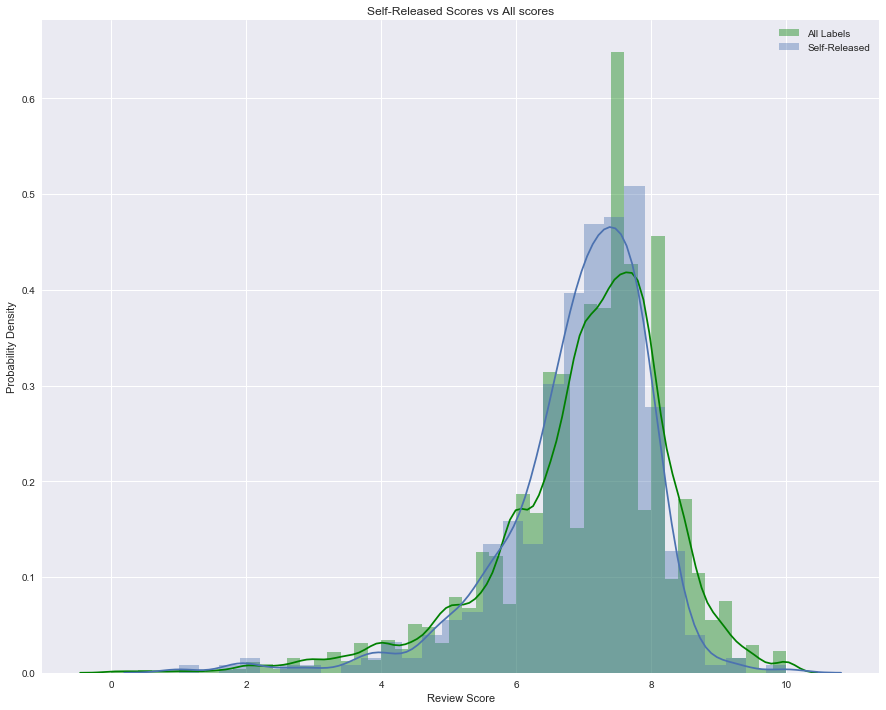

In [10]:
plt.figure(figsize=(15,12))
plt.style.use('seaborn')
sns.distplot(scores_all_labels, color='green', label='All Labels')
sns.distplot(scores_self_released, label='Self-Released');
plt.ylabel('Probability Density')
plt.xlabel('Review Score')
plt.title('Self-Released Scores vs All scores')
plt.legend();

## Test
We will test the hypotheses the question by doing a one sample one-tail z-test since our data is sufficiently large. This is the case for the other hypotheses as well unless otherwise mentioned. This is a one-tail test since $H_a$ is only referencing scores that are lower than the average.

In [11]:
alpha = 0.025

t_val, p_val = stats.ttest_1samp(scores_self_released, mu_review_score)

df = len(scores_self_released)-1
t_crit = stats.t.ppf(alpha, df)

print(f"""
    t_val: {t_val}
    t_crit: {t_crit}
    p_val: {p_val}
    alpha: {alpha}
    """)


    t_val: -1.6196902904798227
    t_crit: -1.9656418415415793
    p_val: 0.10605118857851459
    alpha: 0.025
    


## Evaluate

In [12]:
t_val < t_crit

False

In [13]:
p_val < alpha

False

We were unable to find evidence against the hypothesis that self-released mean scores are equal to the overall album population with the current sample size.

# 2. Are "best new music" albums more prevelant in a certain genre?

## Understand the data

### Data Details
Each album that gets reviewed has the opportunity to be dubbed "Best New Music" (BNM). Most do not receieve this title. Each album also belongs to one particular genre. 

We want to know if the best new music title is given out more often in one or more specific genres. 

### Hypotheses
<b> $H_0=$ BNM albums equally prevalent across genres.

$H_a=$ BNM albums are more prevalent in one of the genres.
</b>
### Statistical Significance  
False positive: We say BNM albums are more prevalent in one or more genres, but they aren't.  
False negative: We say BNM albums are not more prevalent in one or more genres, but they are.    
We prefer to have false positives in this case, because a false negative means Taylor may potentially miss out on an important trend- one genre being "better" than the others. So, we choose   
$$alpha=.1$$   
We're comfortable with being wrong about them being more prevalent in a certain genre one out of 10 times.
Assume we do this same hypothesis test 10 different times, and each time the results tell us to accept that BNM albums are more prevalent in a certain genre. We are okay with being wrong one in ten times, which is fairly often, because if there is even a small chance that we could pick up on a trend, then we want Taylor to pay attention to that trend. If it turns out to be a dead end, that is okay compared to missing a trend. 

However, because we aren't just comparing to the overall population but rather to the spread of BNM titles <i> per genre </i> our alpha will actually need to become smaller to account for all the false positives possible in all the different alphas that one genre depends on. We show that in our work below using the Boneferroni Correction.  

## Prepare the data


In [14]:
# Find mu_bnm
query = """
    SELECT best_new_music
    FROM reviews
    """
result = con.execute(query).fetchall()
bnms = np.array(result)[:,0]

In [15]:
mu_bnm = bnms.mean()
mu_bnm

0.05126950470287609

In [16]:
#Generate List of Genres
query = """
    SELECT genre
    FROM genres
    GROUP BY genre
    """
result = con.execute(query).fetchall()
genres = np.array(result)[:,0]

In [17]:
genres

array(['global', 'experimental', 'metal', None, 'electronic',
       'folk/country', 'pop/r&b', 'jazz', 'rap', 'rock'], dtype=object)

In [18]:
#Drop None from genres, first coerce to list
genres = list(genres)
genres.remove(None)

In [19]:
genres

['global',
 'experimental',
 'metal',
 'electronic',
 'folk/country',
 'pop/r&b',
 'jazz',
 'rap',
 'rock']

In [20]:
#Find bnm frequency
bnm_by_genre = {}
for genre in genres:
    query = f"""
    SELECT best_new_music
    FROM reviews
    JOIN genres
    USING (reviewid)
    WHERE genre = '{genre}'
    """
    result = con.execute(query).fetchall() 
    bnm_array =  np.array(result)[:,0]
    bnm_by_genre[genre]=bnm_array

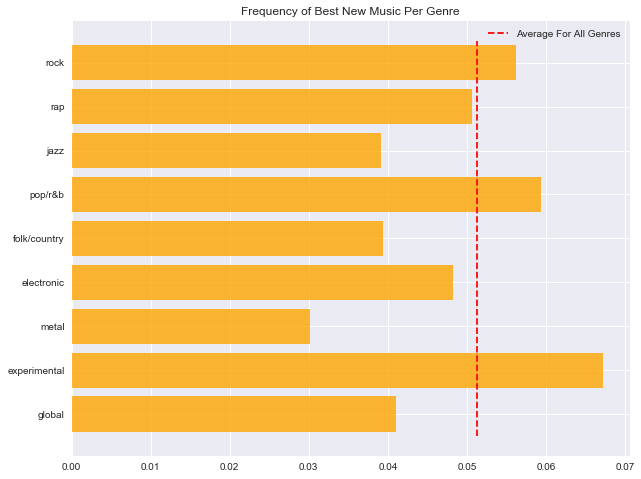

Global: 
     genre mean: 0.0411
  mu population: 0.05127

Experimental: 
     genre mean: 0.06722
  mu population: 0.05127

Metal: 
     genre mean: 0.03016
  mu population: 0.05127

Electronic: 
     genre mean: 0.04827
  mu population: 0.05127

Folk/Country: 
     genre mean: 0.03942
  mu population: 0.05127

Pop/R&B: 
     genre mean: 0.05936
  mu population: 0.05127

Jazz: 
     genre mean: 0.03908
  mu population: 0.05127

Rap: 
     genre mean: 0.05067
  mu population: 0.05127

Rock: 
     genre mean: 0.05616
  mu population: 0.05127



In [21]:
mean_bnms = [bnm_by_genre[genre].mean() for genre in genres]
plt.figure(figsize=(10,8))
plt.barh(genres, mean_bnms, alpha=0.8, color='orange')
plt.vlines(mu_bnm,-0.5,8.5, linestyles='dashed', 
           colors='red', label='Average For All Genres')
plt.legend()
plt.title('Frequency of Best New Music Per Genre')
plt.show()

for genre, mean in zip(genres, mean_bnms):
    print(f'{genre.title()}: \n'
        f'     genre mean: {round(mean, 5)}\n'
        f'  mu population: {round(mu_bnm, 5)}\n')

## Test
This is a one-tail test since $H_a$ is only referencing BNM frequencies that are above the average frequency.

In [22]:
alpha = 0.1
bonferroni_alpha = alpha / len(genres)
bonferroni_alpha

0.011111111111111112

In [23]:
tests_by_genre = {}
for genre in bnm_by_genre:
    bnms = bnm_by_genre[genre]
    t_val, p_val = stats.ttest_1samp(bnms, mu_bnm)
    tests_by_genre[genre] = {
        't_val' : t_val,
        't_crit' : stats.t.ppf(1-bonferroni_alpha, len(bnms) -1),
        'p_val' : p_val,
    }
tests_by_genre

{'global': {'t_val': -0.7566877930227294,
  't_crit': 2.3029922469382376,
  'p_val': 0.45005391992707033},
 'experimental': {'t_val': 2.712667340358848,
  't_crit': 2.2885122631793666,
  'p_val': 0.006737474504092826},
 'metal': {'t_val': -3.6211575950131696,
  't_crit': 2.290690243733693,
  'p_val': 0.00031043031912163075},
 'electronic': {'t_val': -0.870763140434117,
  't_crit': 2.2874675746937077,
  'p_val': 0.3839374628045431},
 'folk/country': {'t_val': -1.593193149477528,
  't_crit': 2.2917644970463025,
  'p_val': 0.1115788415997883},
 'pop/r&b': {'t_val': 1.294829883663111,
  't_crit': 2.289038550669228,
  'p_val': 0.1955877965837994},
 'jazz': {'t_val': -1.3103617221416028,
  't_crit': 2.294779786135665,
  'p_val': 0.19076654702094978},
 'rap': {'t_val': -0.10725778282023768,
  't_crit': 2.288835335272128,
  'p_val': 0.9145982851368573},
 'rock': {'t_val': 2.0618796291729073,
  't_crit': 2.2869252842832197,
  'p_val': 0.03924651490612707}}

## Evaluate

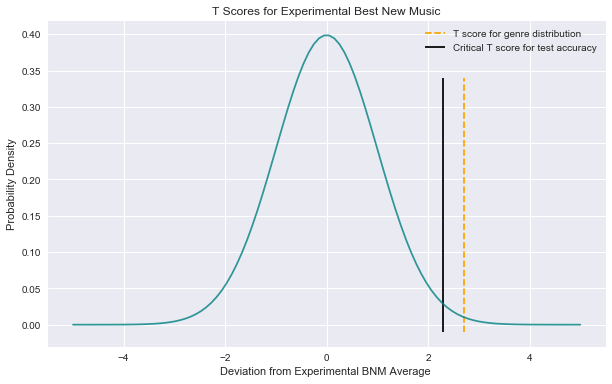

{'t_val': 2.712667340358848, 't_crit': 2.2885122631793666, 'p_val': 0.006737474504092826}


In [53]:
n = len(bnm_by_genre['experimental'])
df = n - 1
x = np.linspace(-5, 5, 100)
y = stats.t.pdf(x, df)

plt.figure(figsize=(10,6))
plt.plot(x,y, color='teal', alpha=0.8)

t = tests_by_genre['experimental']['t_val']
plt.vlines(t, -.01, 0.34, linestyles='dashed', colors='orange', label='T score for genre distribution')

t_crit = tests_by_genre['experimental']['t_crit']
plt.vlines(t_crit, -.01, 0.34, linestyles='-', colors='black', label='Critical T score for test accuracy')

plt.ylabel('Probability Density')
plt.xlabel('Deviation from Experimental BNM Average ')
plt.title('T Scores for Experimental Best New Music')
plt.legend()
plt.show()
print(tests_by_genre['experimental'])

In [25]:
test_results_by_genre = {}
for genre in tests_by_genre:
    t_val = tests_by_genre[genre]['t_val']
    t_crit = tests_by_genre[genre]['t_crit']
    p_val = tests_by_genre[genre]['p_val']
    if t_val > t_crit and np.abs(p_val) < bonferroni_alpha:
        test_results_by_genre[genre] = f'Our findings indicate ' \
        f'that the alternative hypothesis is accepted with a p-val of {p_val}.'
    else: 
        test_results_by_genre[genre] = 'We fail to reject the null hypothesis.'

In [26]:
test_results_by_genre

{'global': 'We fail to reject the null hypothesis.',
 'experimental': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.006737474504092826.',
 'metal': 'We fail to reject the null hypothesis.',
 'electronic': 'We fail to reject the null hypothesis.',
 'folk/country': 'We fail to reject the null hypothesis.',
 'pop/r&b': 'We fail to reject the null hypothesis.',
 'jazz': 'We fail to reject the null hypothesis.',
 'rap': 'We fail to reject the null hypothesis.',
 'rock': 'We fail to reject the null hypothesis.'}

This test fails to find evidence against the fact that BNM albums are equally prevalent across genres except in the case of the experimental genre. Experimental music tends to have more BNM albums.  

# 3. Of the ten most prolific labels, does one label have more "best new music" albums than the others?

## Understand the data

### Hypotheses
<b> $H_0=$ BNM albums are equally prevalent across the ten most prolific labels.

$H_a=$ BNM albums are more prevalent in one or more of the most prolific labels.
</b>
### Statistical Significance  
False positive: We say BNM albums are more prevalent among one or more labels, but they aren't.  
False negative: We say BNM albums are not more prevalent in one or more labels, but they are.  
Simliar to question 2, we prefer to have false positives in this case, because a false negative means Taylor may potentially miss out on one label being "better" than the others. So, we choose   
$$alpha=.1$$ 
Again, we want to err on the side of recognizing a trend instead of missing one. We will use the Boneferroni Correction again in this instance since we are comparing multiple labels.  

## Prepare the data


In [27]:
# Find ten largest labels
query = """
    SELECT count(score), label, avg(best_new_music)
    FROM labels
    JOIN reviews
    USING(reviewid)
    GROUP BY label
    ORDER BY count(score) DESC
    LIMIT 10
    """
result = con.execute(query).fetchall()
top_labels = pd.DataFrame(result, columns=['number_of_reviews', 'label_name', 'avgerage_best_new_music'])
top_labels

for label in top_labels.label_name:
    print(label)

self-released
drag city
sub pop
thrill jockey
merge
warp
domino
columbia
matador
warner bros.


In [28]:
#Find bnm per label from our list
bnm_by_label = {}
for label in top_labels.label_name:
    query = f"""
    SELECT best_new_music
    FROM reviews
    JOIN labels
    USING (reviewid)
    WHERE label = '{label}'
    """
    result = con.execute(query).fetchall() 
    bnm_array =  np.array(result)[:,0]
    bnm_by_label[label]=bnm_array

## Test
This is a one-tail test since $H_a$ is only referencing BNM frequencies that are above the average frequency.

In [29]:
print(mu_bnm, '  ', alpha)

0.05126950470287609    0.1


In [30]:
#Boneferroni correction
bonferroni_alpha = alpha / len(top_labels)
bonferroni_alpha

0.01

In [31]:
tests_by_label = {}
for label in bnm_by_label:
    bnms = bnm_by_label[label]
    t_val, p_val = stats.ttest_1samp(bnms, mu_bnm)
    tests_by_label[label] = {
        't_val' : t_val,
        't_crit' : stats.t.ppf(1-bonferroni_alpha, len(bnms) -1),
        'p_val' : p_val,
    }

## Evaluate

In [32]:
test_results_by_label = {}
for label in tests_by_label:
    t_val = tests_by_label[label]['t_val']
    t_crit = tests_by_label[label]['t_crit']
    p_val = tests_by_label[label]['p_val']
    if np.abs(t_val) > np.abs(t_crit) and np.abs(p_val) < bonferroni_alpha:
        test_results_by_label[label] = f'Our findings indicate ' \
        f'that the alternative hypothesis is accepted with a p-val of {p_val}.'
    else: 
        test_results_by_label[label] = 'We fail to reject the null hypothesis.'

In [33]:
test_results_by_label

{'self-released': 'We fail to reject the null hypothesis.',
 'drag city': 'We fail to reject the null hypothesis.',
 'sub pop': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.0006908554616336897.',
 'thrill jockey': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 9.361615618190903e-25.',
 'merge': 'We fail to reject the null hypothesis.',
 'warp': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.009615855389874585.',
 'domino': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 7.376468407991896e-06.',
 'columbia': 'We fail to reject the null hypothesis.',
 'matador': 'Our findings indicate that the alternative hypothesis is accepted with a p-val of 0.005715176789920098.',
 'warner bros.': 'We fail to reject the null hypothesis.'}

This test fails to find evidence against the fact that BNM albums are equally prevalent across the most prolific labels except in the case of the following labels:  
Sub Pop  
Thrill Jockey  
Warp  
Domino  
Matador  
These labels tend to have more BNM albums than average.  

# 4. Does one reviewer score albums lower than all others? 

## Understand the data

### Data Details
Pitchfork has a lot of authors that write reviews. It is unclear how these authors are chosen or who they are.  
We want to know if there is one reviewer that gives consistently low scores. If we compared all the authors to each other, we would need to use the Bonferonni correction and thus have a very low alpha threshold. Instead of likely accetping the null hypothesis, we will find the reviewer that has an above-average amount of reviews written but the lowest average review score. 

In [34]:
# Find average number of reviews for per reviewer
query = """
    SELECT count(score), author
    FROM reviews
    GROUP BY author
    """
result = con.execute(query).fetchall()
result[:4]

[(2, 'jesse fahnestock'),
 (1, 'edwin stats houghton'),
 (1, 'the pitchfork staff'),
 (62, 'kim kelly')]

In [35]:
num_reviews = [tup[0] for tup in result]
num_reviews[:4]

[2, 1, 1, 62]

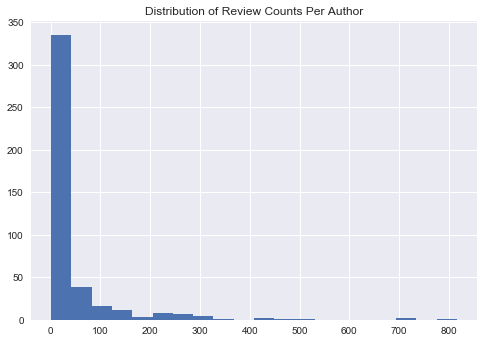

In [36]:
plt.hist(num_reviews,bins=20)
plt.title('Distribution of Review Counts Per Author');

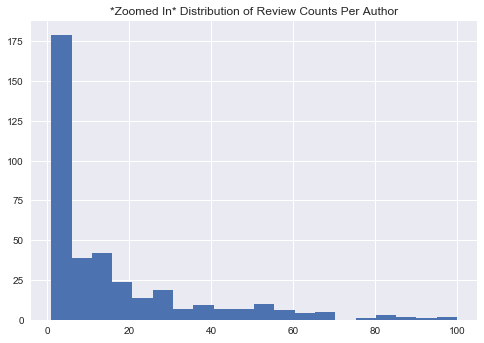

In [37]:
# There are a lot of counts for authors with less reviews.
# Zoom in to the authors with less reviews to analyze the distibution for the bulk of the data.
plt.hist(num_reviews, bins=20, range=(1,100))
plt.title('*Zoomed In* Distribution of Review Counts Per Author');

In [38]:
print('Average Number of Reviews Per Author is:')
print('    ',  np.mean(num_reviews))

Average Number of Reviews Per Author is:
     42.576388888888886


In [39]:
# Which of the authors with more reviews than average are giving the lowest scores???
query = """
    SELECT author, avg(score), count(score)
    FROM reviews
    GROUP BY author
    HAVING count(score) > 42.5
    ORDER BY avg(score)
    LIMIT 10
    """
result = con.execute(query).fetchall()
pd.DataFrame(result, columns=['author', 'avg_score', 'num_reviews'])

,author,avg_score,num_reviews
0,alison fields,5.810870,46
1,adam moerder,6.151675,209
2,brent dicrescenzo,6.163441,93
3,joshua love,6.342056,107
4,liz colville,6.343396,53
5,ian cohen,6.353934,699
6,rob mitchum,6.392884,267
7,jordan sargent,6.486441,59
8,cory d. byrom,6.507937,63
9,evan rytlewski,6.515094,53


In [40]:
# Retrieve Alison Fields' Distribution
query = """
    SELECT score
    FROM reviews
    WHERE author = 'alison fields'
    """
result = con.execute(query).fetchall()
alison_scores = np.array(result)[:,0]

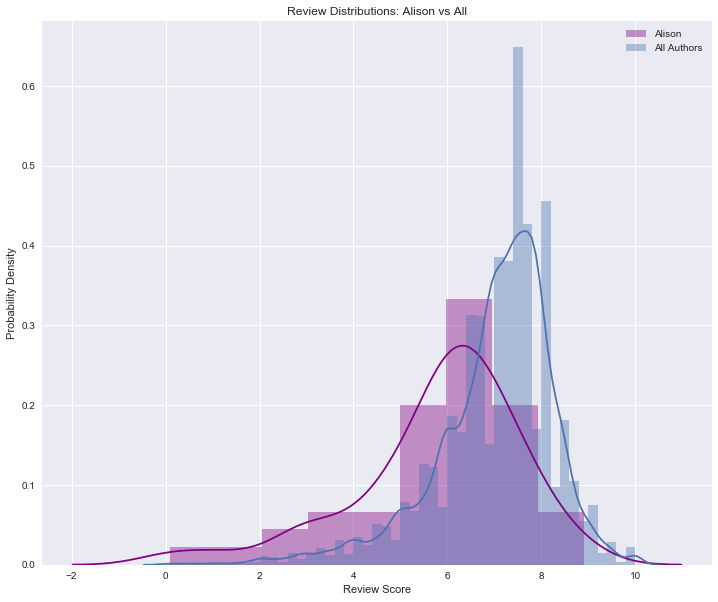

In [41]:
plt.figure(figsize=(12,10))
sns.distplot(alison_scores, color='purple', label='Alison')
sns.distplot(scores_all_labels, label='All Authors')
plt.ylabel('Probability Density')
plt.xlabel('Review Score')
plt.legend()
plt.title('Review Distributions: Alison vs All');

### Hypotheses
<b> $H_0=$ Alison Fields' scores are not much different than all the other scores. 

$H_a=$ Alison Fields' scores are lower than all the other scores.
</b>
### Statistical Significance  
False positive: We say Fields scores lower but she doesn't.
False negative: We say Fields scores are the same but they are lower. 
We prefer to have false positives in this case, because a false negative means Taylor may be influenced by Fields unecessarily, whereas a false positive means she will be extra cautious of anything from Alison Fields. 
$$alpha=.2$$   
We're comfortable with being wrong about Fields scoring lower one in five times. We're this comfortable because she is only one reviewer of many, and there are several other factors that Taylor evaluates by. It's not as if we're firing Fields, but it would be nice to know to ignore her if she is a "troll." 

## Prepare the data


We've already prepared the data when searching for Alison!

## Test
This is a one-tail test since  𝐻𝑎  is only referencing whether Alison rates lower than the average reviewer.

In [42]:
# Alpha is set high to detect the slightest chance of a harsher critic
alpha = 0.2

t_val, p_val = stats.ttest_1samp(alison_scores, mu_review_score)

df = len(alison_scores)-1
t_crit = stats.t.ppf(alpha, df)

print(f"""
    t_val: {t_val}
    t_crit: {t_crit}
    p_val: {p_val}
    alpha: {alpha}
    """)


    t_val: -4.535080661412207
    t_crit: -0.8496819044581843
    p_val: 4.2481512426639494e-05
    alpha: 0.2
    


## Evaluate

In [43]:
t_val < t_crit

True

In [44]:
p_val < alpha

True

This test fails to find evidence that Alison Fields rates all albums equally, and therefore we accept the alternative hypothesis that she scores reviews lower. However, keep in mind our $alpha$ was only .2. There is a 20% chance our results are due to chance. 

# 5. Of the top twenty highest-rated artists from the 2000s, does their recent album get scored better than average?  

## Understand the data

### Data Details
Let's call artists "prolific" if they have at least one album review from 1999-2009 ("the 2000s") and at least one album review from 2014-2017 ("modern times"). Who are the 20 prolific artists that had the highest average album scores from the 2000s? 

In [45]:
# Find artists with best reviews for first decade that ALSO had an album reviewed recently
query = """
    SELECT artist
    FROM reviews 
    WHERE artist in (SELECT artist FROM reviews where pub_date > '2014-01-01') 
    AND pub_date < '2010-01-01' 
    GROUP BY artist
    ORDER BY avg(score) DESC
    LIMIT 20
    """
result = con.execute(query).fetchall()
artists = [tup[0] for tup in result]
artists

['john coltrane',
 'the avalanches',
 'sly and the family stone',
 'the velvet underground',
 'pavement',
 'loretta lynn',
 'jawbox',
 'albert ayler',
 'the feelies',
 'gas',
 'blur',
 'otis redding',
 'elvis presley',
 'this heat',
 'panda bear',
 'rhys chatham',
 'red red meat',
 'nachtmystium',
 'betty davis',
 'ennio morricone']

### Hypotheses
<b> $H_0=$ The artists in this subset do not have scores that are higher than the modern average.

$H_a=$ One or more artist(s) in this subset have higher scores than the modern average.
</b>
### Statistical Significance  
False positive: We say the artists have higher scores than the modern average, but they don't.
False negative: We say the artists do not have higher scores than modern average, but they do. 
We want to minimize false positives because Taylor may spend more time on these promising artists for potential Vegas residencies. We don't want to waste time on artists that wer're not very confident are going to be successful, which would be the case with a false positive. 
$$alpha=.01$$   
We will use the Boneferonni Correction here as well. 

## Prepare the data


In [46]:
# Find average score for recent reviews
query = """
    SELECT score
    FROM reviews
    WHERE pub_date > '2014-01-01'
    """
result = con.execute(query).fetchall()
modern_mu = np.mean(result)
modern_mu

7.149119865884324

In [47]:
# Find scores of artists for modern releases
artist_modern_scores = {}
for artist in artists:
    query = f"""
    SELECT score
    FROM reviews
    WHERE pub_date > '2014-01-01'
    AND artist = '{artist}'
    """
    result = con.execute(query).fetchall()
    scores = [tup[0] for tup in result]
    artist_modern_scores[artist] = scores
artist_modern_scores

{'john coltrane': [10.0, 8.5],
 'the avalanches': [8.5],
 'sly and the family stone': [7.9],
 'the velvet underground': [8.5, 10.0, 10.0, 10.0],
 'pavement': [7.0],
 'loretta lynn': [8.0],
 'jawbox': [7.6],
 'albert ayler': [8.4],
 'the feelies': [7.9],
 'gas': [9.5],
 'blur': [7.0],
 'otis redding': [9.0],
 'elvis presley': [7.0],
 'this heat': [9.0],
 'panda bear': [7.1, 8.7],
 'rhys chatham': [7.6],
 'red red meat': [8.0],
 'nachtmystium': [3.9],
 'betty davis': [6.8],
 'ennio morricone': [8.0]}

## Evaluate
We cannot continue testing because we do not have enough data to sample. In many cases, these artists are not as prolific as we thought, leaving us with only 1 recent album. This doesn't give us enough degrees of freedom to test this sample set. 

# Deployment 

This project is available for perusal at: 
* <a href="https://github.com/MIAISEMAN/mod_2_project">Repository URL </a>
* <a href="https://docs.google.com/presentation/d/1iFk_YmiKlzh46s8aogALnfsZf9R_KxXqXBvpXvXAoNE/edit?usp=sharing">Presentation URL </a>

Best of luck using our findings!